In [1]:
import cv2
import os
import sys

import pandas as pd
import numpy as np
from tabulate import tabulate

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [2]:
import gc
import random
from typing import Tuple

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf
import tensorflow_similarity as tfsim

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

In [3]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.11.0-dev20220730
TensorFlow Similarity 0.16.9


## Import the data

In [52]:
def import_data(path, dim):
    x = []
    y = []
    class_names=[]
    i = 0
    for folder in os.listdir(path):
        class_names.append(folder)
        for filepath in os.listdir(path+folder):
            # import images
            stream = open(u'{0}{1}/{2}'.format(path, folder, filepath), "rb")
            bytes = bytearray(stream.read())
            numpyarray = np.asarray(bytes, dtype=np.uint8)
            bgrImage = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

            # resize
            bgrImage = cv2.resize(bgrImage, dim, interpolation = cv2.INTER_AREA)

            # convert bgr to rgb
            rgbImage = cv2.cvtColor(bgrImage, cv2.COLOR_BGR2RGB)

            # convert to float32
            rgbImage = np.asarray(rgbImage).astype('float32')

            # Check height and width
            if rgbImage.shape[0] == dim[1] and rgbImage.shape[1] == dim[0]:
                x.append(rgbImage / 255)
            else:
                print('Dim Not Matching!')

            y.append(i)
        i += 1

    x = np.asarray(x)
    y = np.asarray(y)

    return x, y, class_names

In [53]:
path = 'xy12_images/'
dim = (120, 185)

x, y, class_names = import_data(path, dim)

['Arcanine', 'Beedrill', 'Blastoise Spirit Link', 'Blastoise-EX', "Brock's Grit", 'Caterpie', 'Chansey', 'Charizard', 'Charizard Spirit Link', 'Charizard-EX', 'Charmander', 'Charmeleon']
(185, 120, 3)


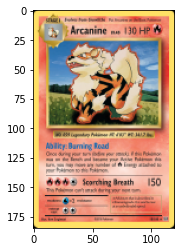

In [6]:
print(class_names)
print(x[0].shape)
plt.imshow(x[2], cmap='gray')

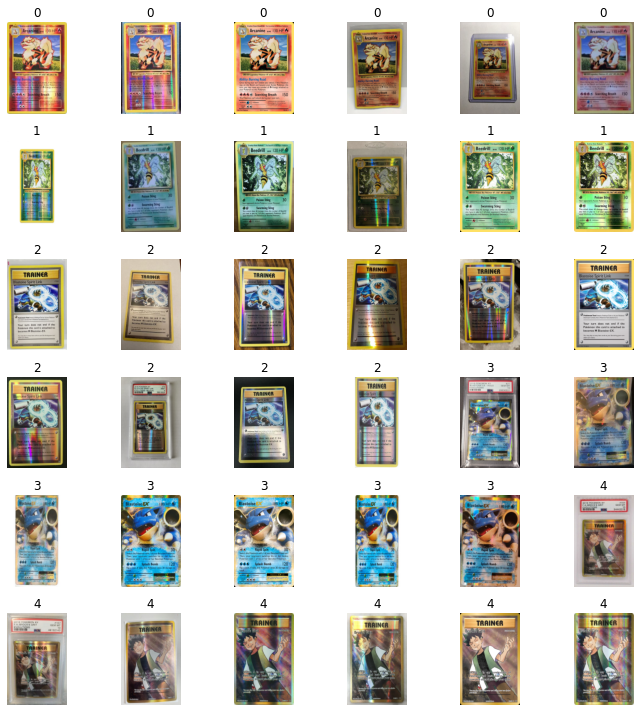

In [7]:
# Plot the first 36 examples
num_imgs = 36
num_row = num_col = 6
sorted_idx = np.argsort(y)
plt.figure(figsize=(10, 10))
for i in range(num_imgs):
    idx = sorted_idx[i]
    ax = plt.subplot(num_row, num_col, i + 1)
    plt.imshow(x[idx])
    plt.title(int(y[idx]))
    plt.axis("off")

plt.tight_layout()

### Split to train and test

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape, 'y_test shape:', y_test.shape)

x_train shape: (74, 185, 120, 3) y_train shape: (74,)
x_test shape: (19, 185, 120, 3) y_test shape: (19,)


## Data Preparation

In [49]:
CLASSES = np.unique(y)
NUM_CLASSES = len(CLASSES)
CLASSES_PER_BATCH = NUM_CLASSES 
EXAMPLES_PER_CLASS = 6 # min number of examples per class
STEPS_PER_EPOCH = 100  # @param {type:"integer"}

## Augmentor

In [10]:
# aug_num_examples_per_batch = 18  # @param {type:"slider", min:18, max:512}
# aug_num_augmentations_per_example = 1  # @param {type:"slider", min:1, max:3}

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.05, 0.2)),
    ]
)


def augmenter(
    x: tfsim.types.FloatTensor, y: tfsim.types.IntTensor, examples_per_class: int, is_warmup: bool, stddev=0.05
) -> Tuple[tfsim.types.FloatTensor, tfsim.types.IntTensor]:
    """Image augmentation function.

    Args:
        X: FloatTensor representing the example features.
        y: IntTensor representing the class id. In this case
           the example index will be used as the class id.
        examples_per_class: The number of examples per class.
           Not used here.
        is_warmup: If True, the training is still in a warm
           up state. Not used here.
        stddev: Sets the amount of gaussian noise added to
           the image.
    """
    _ = examples_per_class
    _ = is_warmup

    aug = tf.squeeze(data_augmentation(x))
    aug = aug + tf.random.normal(tf.shape(aug), stddev=stddev)
    x = tf.concat((x, aug), axis=0)
    y = tf.concat((y, y), axis=0)
    idxs = tf.range(start=0, limit=tf.shape(x)[0])
    idxs = tf.random.shuffle(idxs)
    x = tf.gather(x, idxs)
    y = tf.gather(y, idxs)
    return x, y


# aug_sampler = tfsim.samplers.SingleShotMemorySampler(
#     x_train,
#     augmenter=augmenter,
#     examples_per_batch=aug_num_examples_per_batch,
#     num_augmentations_per_example=aug_num_augmentations_per_example,
# )

sampler = tfsim.samplers.MultiShotMemorySampler(
    x_train,
    y_train,
    augmenter=augmenter,
    classes_per_batch=CLASSES_PER_BATCH,
    examples_per_class_per_batch=EXAMPLES_PER_CLASS,
    class_list=list(CLASSES[:NUM_CLASSES]),
    steps_per_epoch=STEPS_PER_EPOCH,
)


The initial batch size is 72 (12 classes * 6 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/74 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/12 [00:00<?, ?it/s]

gather examples:   0%|          | 0/74 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/74 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

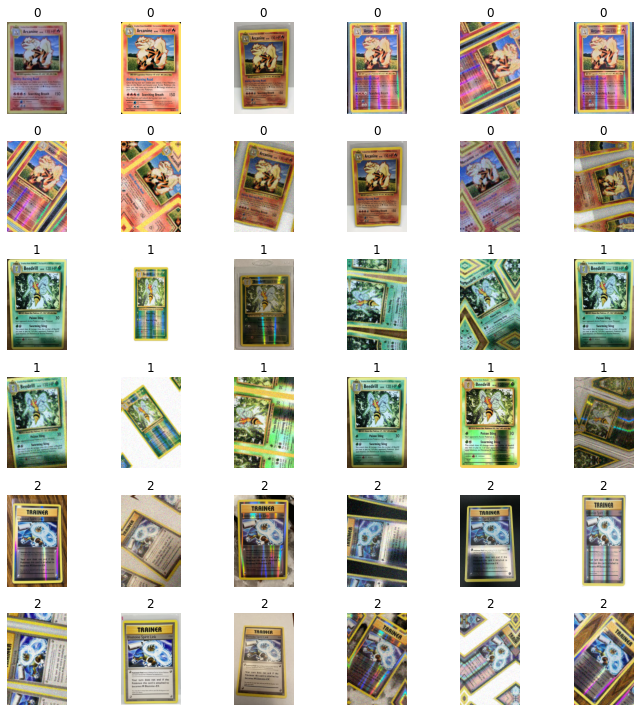

In [11]:
# Plot the first 36 examples
num_imgs = 36
num_row = num_col = 6
aug_batch_x, aug_batch_y = sampler[0]
# Sort the class ids so we can see the original
# and augmented versions as pairs.
sorted_idx = np.argsort(aug_batch_y)
plt.figure(figsize=(10, 10))
for i in range(num_imgs):
    idx = sorted_idx[i]
    ax = plt.subplot(num_row, num_col, i + 1)
    plt.imshow(aug_batch_x[idx])
    plt.title(int(aug_batch_y[idx]))
    plt.axis("off")

plt.tight_layout()

In [12]:
print(f"The sampler contains {len(sampler)} steps per epoch.")
print(f"The sampler is using {sampler.num_examples} examples out of the original {len(x_train)}.")
print(f"Each examples has the following shape: {sampler.example_shape}.")

The sampler contains 100 steps per epoch.
The sampler is using 74 examples out of the original 74.
Each examples has the following shape: (185, 120, 3).


## Setup the model

In [13]:
print(x_train.shape)
tf.keras.backend.image_data_format()

(74, 185, 120, 3)


In [15]:
def get_model(dim):
    inputs = tf.keras.layers.Input(shape=(dim[1], dim[0], 3))
#     x = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = tfsim.layers.MetricEmbedding(256)(x)
    return tfsim.models.SimilarityModel(inputs, outputs)


model = get_model(dim)
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 185, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 183, 118, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 181, 116, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 58, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 56, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 86, 54, 64)        36928     
                                                  

In [32]:
distance = "cosine"  # @param ["cosine", "L2", "L1"]{allow-input: false}
loss = tfsim.losses.MultiSimilarityLoss(distance=distance)

In [33]:
LR = 0.000005  # @param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss)

Distance metric automatically set to euclidean use the distance arg to override.


In [34]:
EPOCHS = 5  # @param {type:"integer"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/5
100/100 [==============================] - 125s 1s/step - loss: 0.0934 - val_loss: 0.1922
Epoch 2/5
100/100 [==============================] - 123s 1s/step - loss: 0.0309 - val_loss: 0.1809
Epoch 3/5
100/100 [==============================] - 122s 1s/step - loss: 0.0177 - val_loss: 0.1824
Epoch 4/5
100/100 [==============================] - 122s 1s/step - loss: 0.0112 - val_loss: 0.1906
Epoch 5/5
 49/100 [=============>................] - ETA: 1:01 - loss: 0.0078

KeyboardInterrupt: 

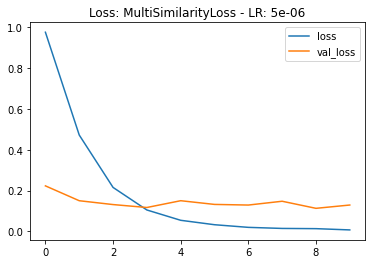

In [35]:
# expect loss: 0.14 / val_loss: 0.33
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

In [36]:
x_index, y_index = tfsim.samplers.select_examples(x_train, y_train, CLASSES, 20)
model.reset_index()
model.index(x_index, y_index, data=x_index)

filtering examples:   0%|          | 0/74 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/12 [00:00<?, ?it/s]

gather examples:   0%|          | 0/240 [00:00<?, ?it/s]

[Indexing 240 points]
|-Computing embeddings
8/8 [==============================] - 0s 45ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


filtering examples:   0%|          | 0/19 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/12 [00:00<?, ?it/s]

gather examples:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step

Performing NN search



Building NN list:   0%|          | 0/12 [00:00<?, ?it/s]

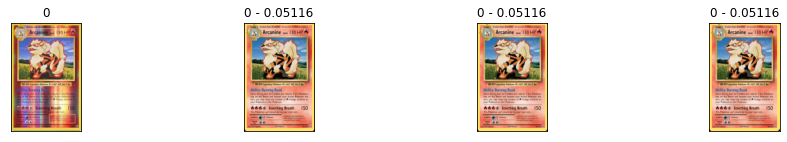

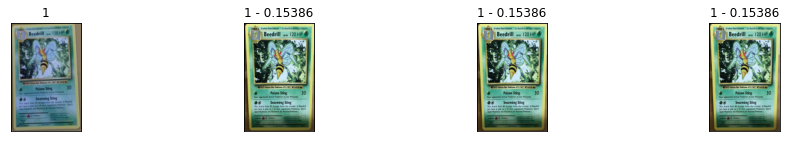

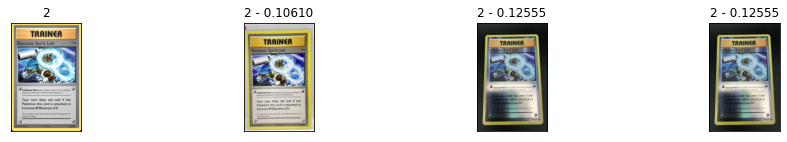

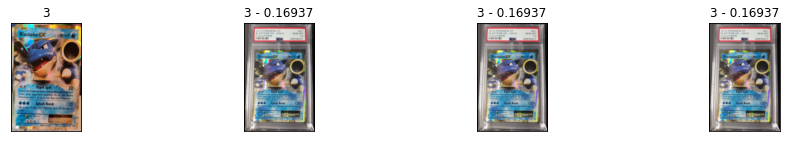

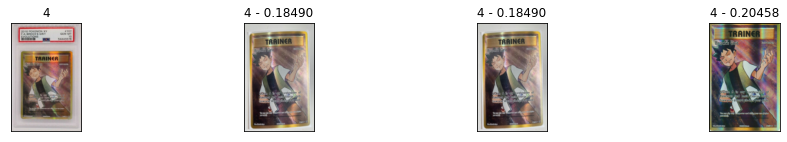

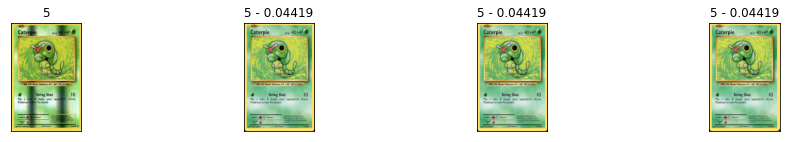

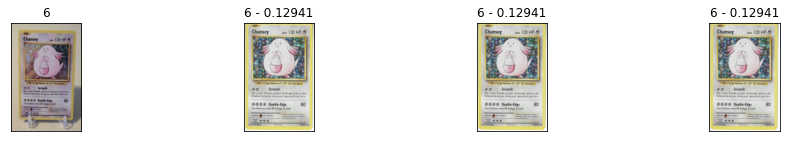

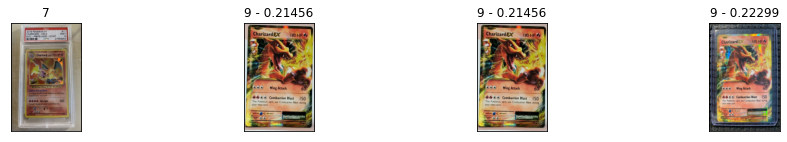

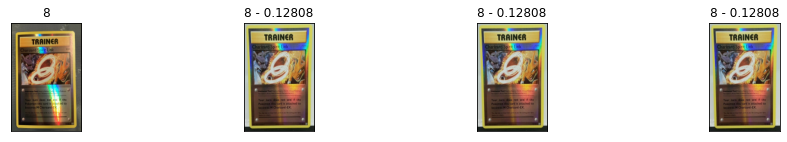

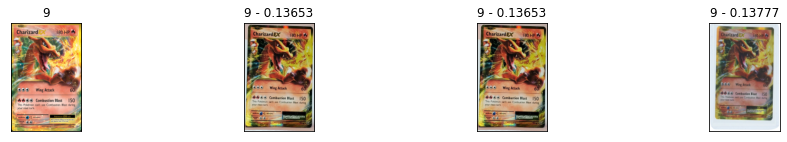

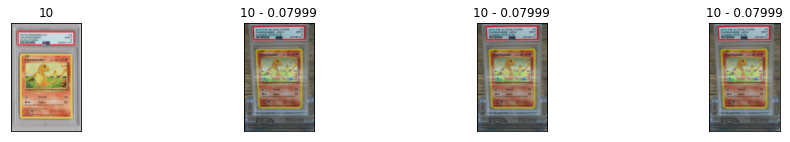

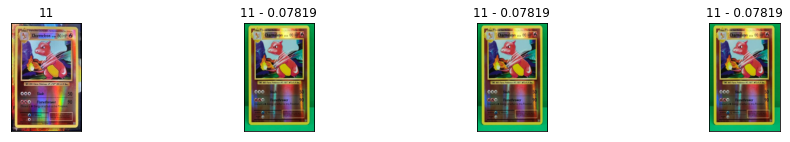

In [45]:
# re-run to test on other examples
num_neighbors = 3

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2))

### Calibration

To be able to tell if an example matches a given class, we first need to calibrate() the model to find the optimal cut point. This cut point is the maximum distance below which returned neighbors are of the same class. Increasing the threshold improves the recall at the expense of the precision.

By default, the calibration uses the F-score classification metric to optimally balance out the precsion and recalll; however, you can speficy your own target and change the calibration metric to better suite your usecase.

In [46]:
num_calibration_samples = x_train.shape[0]  # @param {type:"integer"}
calibration = model.calibrate(
    x_train[:num_calibration_samples],
    y_train[:num_calibration_samples],
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)

3/3 [==============================] - 0s 153ms/step

Performing NN search



Building NN list:   0%|          | 0/74 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


 name       value    distance    precision    recall    binary_accuracy    f1
-------  -------  ----------  -----------  --------  -----------------  ----
optimal        1   0.0569764            1         1                  1     1


### Metrics ploting

Let's plot the performance metrics to see how they evolve as the distance threshold increases.

We clearly see an inflection point where the precision and recall intersect, however, this is not the optimal_cutpoint because the recall continues to increase faster than the precision decreases. Different usecases will have different performance profiles, which why each model needs to be calibrated.

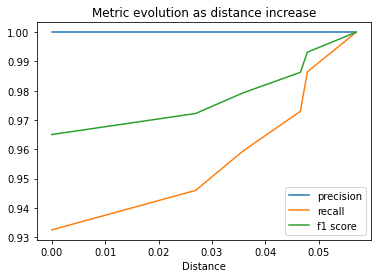

In [39]:
fig, ax = plt.subplots()
x = calibration.thresholds["distance"]
ax.plot(x, calibration.thresholds["precision"], label="precision")
ax.plot(x, calibration.thresholds["recall"], label="recall")
ax.plot(x, calibration.thresholds["f1"], label="f1 score")
ax.legend()
ax.set_title("Metric evolution as distance increase")
ax.set_xlabel("Distance")
plt.show()

### Precision/Recall curve

We can see in the precision/recall curve below, that the curve is not smooth. This is because the recall can improve independently of the precision causing a seesaw pattern.

Additionally, the model does extremly well on known classes and less well on the unseen ones, which contributes to the flat curve at the begining followed by a sharp decline as the distance threshold increases and examples are further away from the indexed examples.

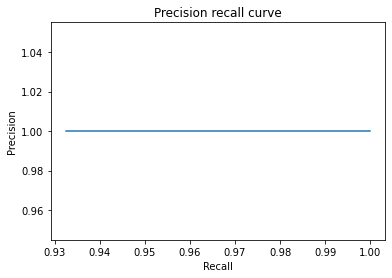

In [40]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision recall curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

### Matching

The purpose of match() is to allow you to use your similarity models to make classification predictions. It accomplishes this by finding the nearest neigbors for a set of query examples and returning an infered label based on neighbors labels and the matching strategy used (MatchNearest by default).

Note: unlike traditional models, the match() method potentially returns -1 when there are no indexed examples below the cutpoint threshold. The -1 class should be treated as "unknown".

In [48]:
num_matches = 10  # @param {type:"integer"}

matches = model.match(x_test[:num_matches], cutpoint="optimal")
rows = []
for idx, match in enumerate(matches):
    rows.append([match, y_test[idx], match == y_test[idx]])
print(tabulate(rows, headers=["Predicted", "Expected", "Correct"]))

1/1 [==============================] - 0s 14ms/step
  Predicted    Expected    Correct
-----------  ----------  ---------
          5           5          1
         -1           3          0
         -1           8          0
         -1          10          0
          0           0          1
         -1           3          0
         -1           5          0
         -1           9          0
         -1           1          0
         -1           6          0


### confusion matrix

Now that we have a better sense of what the match() method does, let's scale up to a few thousand samples per class and evaluate how good our model is at predicting the correct classes.

As expected, while the model prediction performance is very good, its not competitive with a classification model. However this lower accuracy comes with the unique advantage that the model is able to classify classes that were not seen during training.

filtering examples:   0%|          | 0/19 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/12 [00:00<?, ?it/s]

gather examples:   0%|          | 0/72 [00:00<?, ?it/s]

3/3 [==============================] - 0s 19ms/step


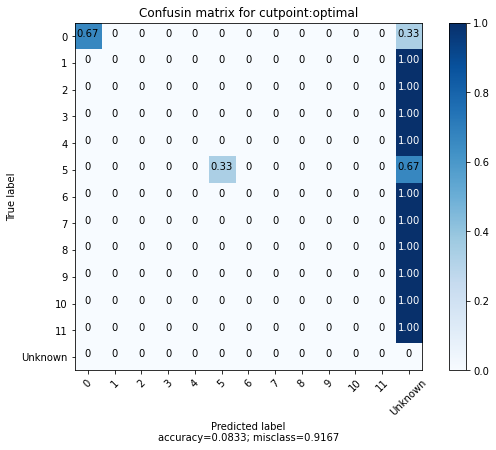

In [42]:
# used to label in images in the viz_neighbors_imgs plots
# note we added a 11th classes for unknown
# labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "Unknown"]
labels = np.append(CLASSES, "Unknown")
num_examples_per_class = EXAMPLES_PER_CLASS
cutpoint = "optimal"

x_confusion, y_confusion = tfsim.samplers.select_examples(x_test, y_test, CLASSES, num_examples_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=len(labels)-1)
cm = tfsim.visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=labels,
    title="Confusin matrix for cutpoint:%s" % cutpoint,
)

### Index information

Following model.summary() you can get information about the index configuration and its performance using index_summary().

In [43]:
model.index_summary()

[Info]
------------------  ---------
distance            euclidean
key value store     memory
search algorithm    nmslib
evaluator           memory
index size          240
calibrated          True
calibration_metric  f1
embedding_output
------------------  ---------



[Performance]
-----------  -------------
num lookups  177
min            4.16636e-05
max            0.00137504
avg            0.000214695
median         0.00018421
stddev         0.000321901
-----------  -------------


### Saving and reloading

Saving and reloading the model works as you would expected:

model.save(path, save_index=True): save the model and the index on disk. By default the index is compressed but this can be disabled by setting compressed=False

model = tf.keras.model.load_model(path, custom_objects={"SimilarityModel": tfsim.models.SimilarityModel}) reload the model.

NOTE: We need to pass SimilarityModel as a custom object to ensure that Keras knows about the index methods.

model.load_index(path) Is requried to reload the index.

model.save_index(path) and model.load_index(path) allows to save/reload an index independently of saving/loading a model.

In [47]:
# save the model and the index
save_path = "models/pokemon_image_classifier_v2"  # @param {type:"string"}
model.save(save_path, save_index=True)